# Статистика, DS-поток
## Задание SP.10

Задача 2: Визуализация проблемы подглядывания.
▫️ Наличие решения. (30.0)
▫️ Не выписаны формулы. (-5.0)
Баллы: 25.0 / 30.0

Задача 3: Проверка признаков на нормальность и комбинирование с помощью МПГ.
▫️ Наличие решения. (90.0)
▫️ Не обоснован выбор критериев. (-7.0)
▫️ Неполный вывод. (-5.0)
Баллы: 78.0 / 90.0

Задача 4: Реализация МПГ.
▫️ Наличие решения. (100.0)
▫️ Методы реализованы без циклов. (5.0)
Баллы: 105.0 / 100.0

In [9]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.sandbox.stats.multicomp import multipletests
from collections import Counter
from tqdm.notebook import tqdm
import pandas as pd
from scipy.stats import binom

%matplotlib inline
sns.set(style='ticks', font_scale=1.7)

_____
### Задача P2. 20 баллов

Пусть $X_1, ..., X_n \sim Bern(p)$.
Известно, что $S_n = \left\{\sum_{i=1}^n x_i > c_{n,\alpha}\right\}$ является равномерно наиболее мощным критерием для проверки $\mathsf{H}_0\colon p=1/2\ vs.\ \mathsf{H}_1\colon p>1/2$, где $\alpha$ &mdash; уровень значимости.

Некоторая компания решила воспользоваться этим критерием для решения одной своей задачи. Например, это может быть исследование конверсии в клик, заполнении формы, указания номера телефона, и тд. Конверсия &mdash; доля пользователей, которая совершит определенное целевое действие.

Данные приходят онлайн, но не так часто. Для простоты задачи будем считать, что данные приходят по одному наблюдению в сутки. Однако, маркетологи не хотят долго ждать, и решают проверять гипотезу каждый день с помощью имеющихся на текущий момент данных.
То есть в $k$-й день они пользуются критерием $S_k$, имея выборку $X_1, ..., X_k$.
Если же в один из дней соответствующий критерий дает положительный результат (т.е. отклоняет $\mathsf{H}_0$), то маркетологи завершают наблюдения, иначе &mdash; продолжают тестирование.

Промоделируйте подобную процедуру в течение 100 дней в предположении справедливости $\mathsf{H}_0$.

In [23]:
sample = sps.bernoulli(0.5).rvs(size=(100,))
p_value = sps.binom(n=np.arange(1, 101), p=0.5).sf(sample.cumsum() - 1)
rejected = np.argwhere(p_value < 0.05)

Повторите данный эксперимент достаточное количество раз и по результатам оцените вероятность ошибки I рода в случае если компания проводит эксперимент не более $n$ дней. Постройте ее график в зависимости от $n$.

In [24]:
n = 10000
sample = sps.bernoulli(0.5).rvs(size=(n, 1000,))
p_value = sps.binom(n=np.arange(1, 1001), p=0.5).sf(sample.cumsum(axis=-1) - 1)
pIs = (np.minimum.accumulate(p_value, axis=-1) < 0.05).sum(axis=0) / n

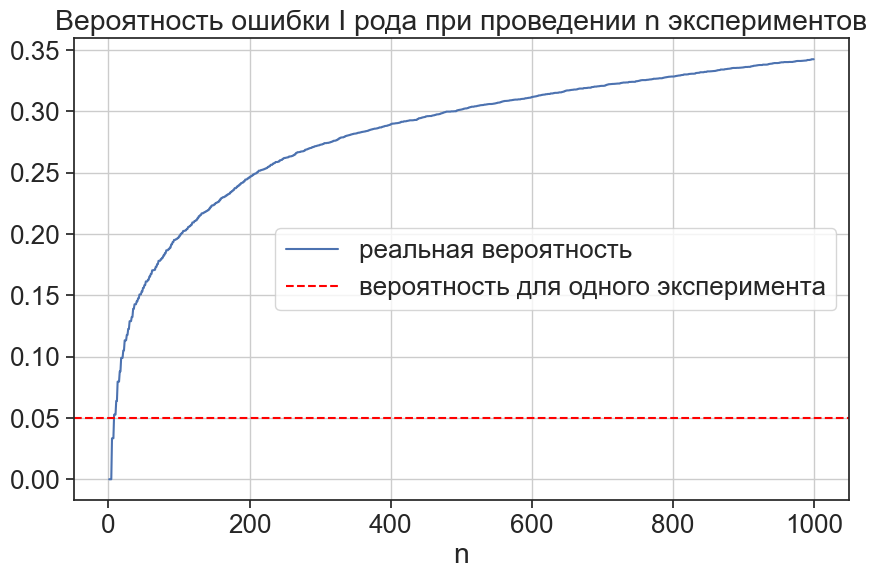

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 1001), pIs, label='реальная вероятность')
plt.axhline(0.05, label='вероятность для одного эксперимента', color='red', linestyle='--')
plt.xlabel('n')
plt.title('Вероятность ошибки I рода при проведении n экспериментов')
plt.legend()
plt.grid()
plt.show()

Сделайте выводы

Видим, что вероятность ошибки 1го рода увеличивается примерно как $\sqrt(n)$ при таком подходе. Поэтому необходимо делать поправку на множественное тестирование

*Замечание.* В статистике (в т.ч. в АБ-тестировании) подобный эффект называется *проблемой подглядывания* (peeking problem). Размер выборки для применения критерия должен быть определен заранее, его нельзя как-то сокращать на основе полученных данных, даже если бизнесу очень хочется.

___________
### Задача P3.

*Примечание.* Задача достаточно простая, кода здесь мало. Основное количество баллов дается за ответы на вопросы. Не забывайте также смотреть в ноутбуки с семинаров.

Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a>, взяв все признаки, кроме `Class`.

In [28]:
data = pd.read_csv('wine.data', header=None)
data.columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                'Flavanoids', 'Nonflavanoid phenols',
                'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

data.drop('Class', axis=1, inplace=True)
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Для каждого из признаков нарисуйте Q-Q plot. Для наглядности и экономии места рисуйте графики в несколько столбцов, используя `plt.subplot`.

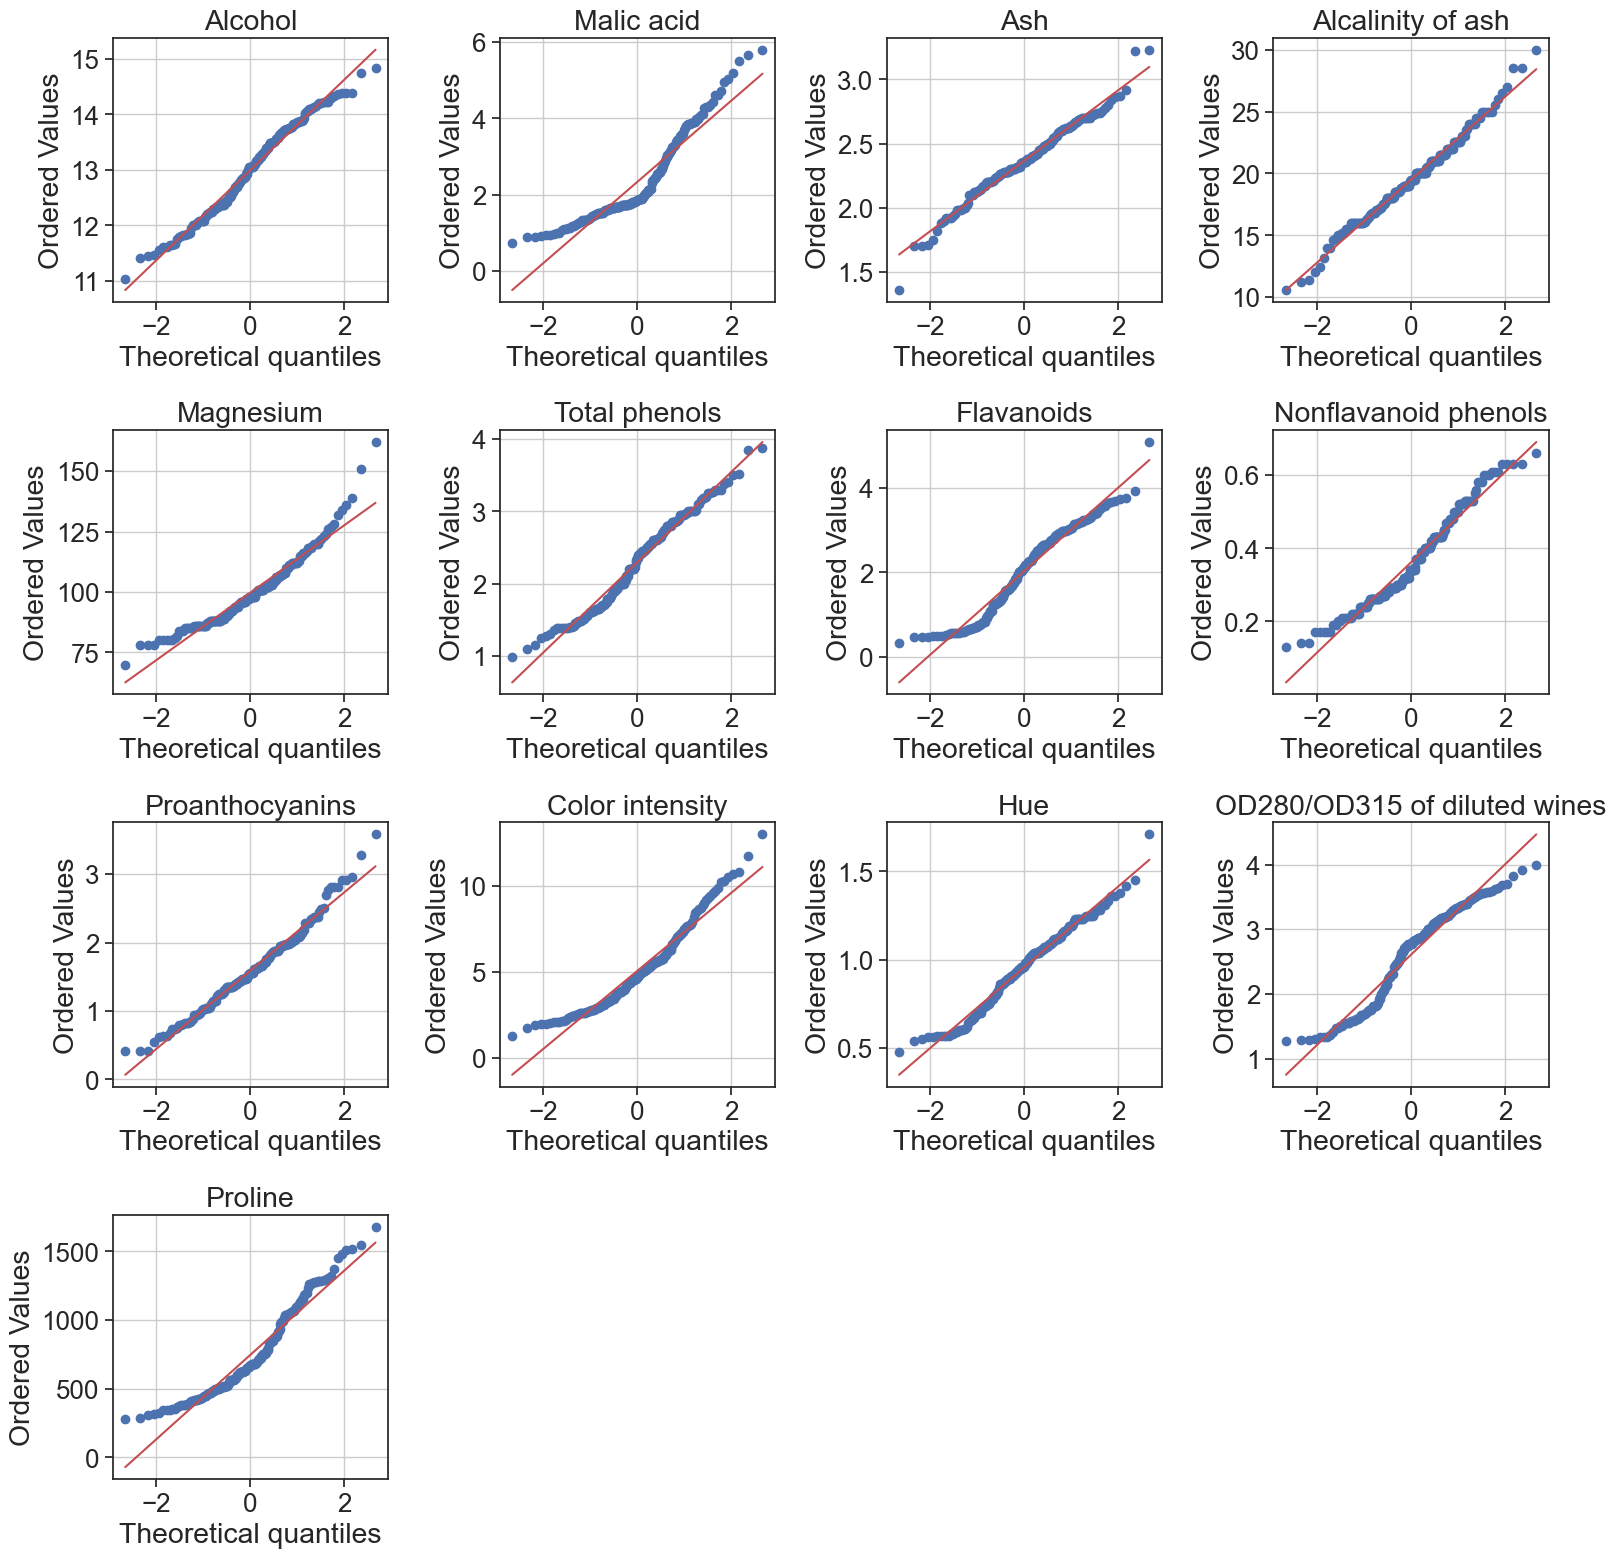

In [30]:
plt.figure(figsize=(16, 16))

for i, col in enumerate(data.columns):
    plt.subplot(4, 4, i + 1)
    sps.probplot(x=data[col], dist='norm', fit=True, plot=plt)
    plt.grid()
    plt.title(col)

plt.tight_layout()

Для каких признаков можно говорить об их нормальности и почему?

**Ответ:** 
Alcohol, Ash, Alcalinity of Ash, Total Phenols, Proanthocyanins, Hue, поскольку точки на Q-Q plot лежат практически на одной прямой. Точки на Q-Q графике должны лежать на прямой линии при нормальных данных, потому что Q-Q график сравнивает квантильное распределение наших данных с квантильным распределением теоретической нормальной выборки. Если наши данные также имеют нормальное распределение, их квантили будут пропорциональны теоретическим квантилям нормального распределения.

Проверьте нормальность каждого признака статистическими критериями. Прежде чем выполнить следующую часть задачи, ответьте на вопросы. Помочь в этом может теоретический материал и выполненные ранее задачи.

Для каждого признака используйте несколько критериев проверки нормальности. Какие критерии вы будете использовать?

**Ответ:** 
Шапиро-Уилка,  Жарка-Бера

Результаты критериев нужно обработать с помощью *одной* процедуры множественной проверки гипотез для всех признаков и всех критериев сразу. Почему так нужно делать?

**Ответ:** 

Проблема множественного тестирования.
При проверке нормальности каждого признака несколькими критериями мы проводим множество независимых гипотез. Если мы будем интерпретировать результаты без учета этой множественности, то:
- Вероятность ложноположительных результатов (ошибок I рода) значительно увеличивается.
- Например, если мы проверяем 10 признаков 3 критериями, то проводим 30 тестов. При уровне значимости $\alpha = 0.05$, вероятность хотя бы одной ложноположительной ошибки составляет:
  $$
  P(\text{ошибка хотя бы в одном тесте}) = 1 - (1 - \alpha)^{30} \approx 0.785
  $$
  Это недопустимо высоко.

Используя одну процедуру коррекции, мы учитываем все тесты (по всем признакам и критериям), что предотвращает накопление ошибок I рода.
- Все признаки анализируются по одинаковым условиям, и мы можем однозначно сказать, какие из них проходят проверку на нормальность.
- Объединяя тесты, мы контролируем глобальный уровень ошибки FWER или FDR.

Какой метод для контроля FWER стоит применить и почему?

**Ответ:** 
Холма, поскольку он всегда мощнее метода Бонферрони

Как понять из результата процедуры множественной проверки гипотез, нормальность каких признаков следует отклонить?

**Ответ:** 
Отклоняются те, у которых скорр. $p-value$ > $\alpha$

Если нормальность не отклоняется, что можно сказать про выборку? Ответ находится в презентации с лекции.

**Ответ:**
Данные согласуются с нулевой гипотезой, то есть не противоречат свойствам нормальности.

Реализуйте данную схему. Предварительно соберите p-value всех критериев в таблицу.

Функция `multipletests` принимает только одномерные массивы, поэтому для полученной `numpy`-таблицы нужно воспользоваться методом `ravel`. Результаты соберите обратно в таблицу с помощью метода `reshape`, которому необходимо передать размерности таблицы. Для наглядности сделайте таблицу с помощью `pandas.DataFrame`. В качестве названий строк используйте названия признаков, а названий столбцов — используемые критерии. В таблице должны присутстововать как значения p-value, так и результат проверки (`True` в случае отвержения).

In [31]:
crits = [sps.shapiro, sps.jarque_bera]
pvalues = []

for i in range(data.columns.shape[0]):
    pvalues.append([crits[0](np.array(data)[:, i]).pvalue, crits[1](np.array(data)[:, i]).pvalue])

pvalues = np.array(pvalues)
pvalues = pd.DataFrame(pvalues, index=data.columns, columns=['Кр. Шапиро-Уилка', 'Кр. Жака-Бера'])
pvalues

,Кр. Шапиро-Уилка,Кр. Жака-Бера
Alcohol,2.005071e-02,6.106775e-02
Malic acid,2.945822e-10,1.115426e-07
Ash,3.869102e-02,8.485917e-03
Alcalinity of ash,2.639486e-01,2.509338e-01
Magnesium,6.345416e-07,6.865214e-15
Total phenols,4.394717e-03,6.312188e-02
Flavanoids,1.679064e-05,5.273120e-02
Nonflavanoid phenols,1.055268e-04,1.071359e-02
Proanthocyanins,1.445252e-02,7.840977e-03
Color intensity,9.230111e-07,1.092262e-05


Для каких признаков нормальность не отвергается?

In [ ]:
rejects = multipletests(pvalues.values.ravel(), method='holm')[0].reshape(-1, 2)
rejects = pd.DataFrame(rejects, index=data.columns, columns=['Кр. Шапиро-Уилка', 'Кр. Жарка-Бера'])
rejects

,Кр. Шапиро-Уилка,Кр. Жарка-Бера
Alcohol,False,False
Malic acid,True,True
Ash,False,False
Alcalinity of ash,False,False
Magnesium,True,True
Total phenols,False,False
Flavanoids,True,False
Nonflavanoid phenols,True,False
Proanthocyanins,False,False
Color intensity,True,True


In [33]:
rejects[~rejects['Кр. Шапиро-Уилка'] & ~rejects['Кр. Жарка-Бера']]

,Кр. Шапиро-Уилка,Кр. Жарка-Бера
Alcohol,False,False
Ash,False,False
Alcalinity of ash,False,False
Total phenols,False,False
Proanthocyanins,False,False
Hue,False,False


**Ответ:** 
Мы получили те же признаки, что и при визуальном анализе

**Вывод:** 
Двумя методами получили один и тот же результат, значит, скорее всего он правильный.

---
### Задача P4.

Исследуем влияние методов коррекции при множественной проверке гипотез на различные показатели качества.

**Теоретическая справка**

Приведем определения всех составляющих:
* $V_{\mathsf{P} S}(X)$ &mdash; количество верных гипотез, которые были отвергнуты для $\mathsf{P}$ критерием $S$ по выборке $X$,
* $R_S(X)$ &mdash; количество отвергнутых гипотез критерием $S$ по выборке $X$,
* $U_{\mathsf{P} S}(X)$ &mdash; количество *не*верных гипотез, которые были отвергнуты для $\mathsf{P}$ критерием $S$ по выборке $X$,
* $T_{\mathsf{P}}$ &mdash; количество *не*верных гипотез для $\mathsf{P}$.

Тогда характеристики определяются следующим образом.
* Вероятность хотя бы одного неверного отвержения
$$FWER = \mathsf{P}(V_{\mathsf{P} S}(X) > 0).$$

* Ожидаемая доля ложных отклонений среди всех отвергнутых гипотез
$$FDR = \mathsf{E}_\mathsf{P} \frac{V_{\mathsf{P} S}\;(X)}{\max(R_S(X), 1)}.$$

* Ожидаемая доля правильный отклонений среди всех неверных гипотез
$$Power = \mathsf{E}_\mathsf{P} \frac{U_{\mathsf{P} S}\;(X)}{\max(T_{\mathsf{P}}, 1)}.$$

**Постановка задачи**

Дана выборка $X = (X_1, ..., X_n)$ из многомерного нормального распределения с неизвестным вектором средних ${\theta}$ и известной матрицей ковариаций ${\Sigma}$.
Для каждой из компонент вектора проверяется гипотеза $\mathsf{H}_j\colon\ \theta_j = 0$ против правосторонней альтернативы. Соответственно, используется правосторонний критерий на основе выборочного среднего, который является при этом равномерно наиболее мощным.


*Задача*: исследовать, как ведут себя характеристики процедур МПГ в зависимости от
1. количества верных гипотез,
2. используемой процедуры МПГ,
3. степени скоррелированности компонент.

*Пояснения по каждому пункту.*

1. Для упрощения задачи будем рассматривать простую альтернативную гипотезу $\mathsf{H}'_j\colon\ \theta_j = \theta_{1j}$, где $\theta_{1j} > 0$ &mdash; фиксированное положительное число. На самом деле конкретный выбор $\theta_{1j}$ влияет только на масштаб. Тем самым мы концентрируемся на верности/неверности гипотезы, а не на конкретных распределениях их альтернативы.


2. Исследуемые методы корректировки:
    * отсутствие корректировки,
    * метод Бонферрони,
    * метод Холма,
    * метод Бенджамини-Иекутиелли.
    
*Можно также исследовать только часть методов и получить за это часть баллов.*


3. Для исследования степени скоррелированности будем рассматривать такие матрицы ковариаций ${\Sigma}$, у которых на диагонали стоит 1, а вне диагонали &mdash; число $\gamma \in [0, 1]$, отвечающее за корреляцию выборок. Напомним, при $\gamma=0$ выборки независимы, а при $\gamma=1$ выборки идентичны. Соответственно, в процессе исследования изучим поведение характеристик для независимых, зависимых, идентичных выборок.



**Исследование**

Для проведения исследования вам нужно реализовать примерно следующую процедуру.
* перебираем исследуемые варианты распределения данных, то есть числа $\gamma$
    * перебираем все комбинации верных/неверных гипотез
        * совершаем достаточно много итераций метода Монте-Карло
            * генерируем выборку
            * добавляем смещение в тех случаях, где основная гипотеза не верна
            * применяем критерий
            * для рассматриваемых методов МПГ:
                * применяем корректировку
                * сохраняем числа V, R, U, T
        * оцениваем FWER, FDR, Power
        

Поскольку с помощью Монте-Карло мы оцениваем разные величины, *для ускорения процедуры и получения менее шумных графиков* можно использовать одинаковые семплы для разных процедур. Тем самым схема получается следующая
* совершаем достаточно много итераций метода Монте-Карло
    * генерируем выборку с независимыми компонентами
    * перебираем исследуемые варианты распределения данных, то есть числа $\gamma$
        * меняем матрицу ковариаций (нужно домножить на корень из матрицы)
        * перебираем все комбинации верных/неверных гипотез
            * добавляем смещение в тех случаях, где основная гипотеза не верна
            * применяем критерий
            * для рассматриваемых методов МПГ:
                * применяем корректировку
                * сохраняем числа V, R, U, T
* оцениваем FWER, FDR, Power во всех случаях

*Вторая схема работает быстрее, но немного сложнее в реализации. <u>Вы можете реализовать любую схему.</u>*


**Рекомендации и замечания:**
* для ускорения вычислений реализуйте критерий, принимающий выборку векторов, и использующий усреднение по указанной оси;
* реализацию метода Бонферонни можно взять из `statsmodels`, она работает достаточно быстро;
* реализацию методов Холма и Бенджамини-Иекутиелли тоже можно взять из `statsmodels`, но они работают существенно дольше;
* эти методы можно реализовать самостоятельно без циклов, причем возвращать достаточно *только вектор результатов* (1 &mdash; гипотеза отвергается, 0 &mdash; не отвергается), скорректированные p-value для исследования вычислять не требуется;
* при реализации методов помогут функции `np.argsort` для пересортировки гипотез и `np.cumprod` для бинарного массива с целью выполнения нисходящей/восходящей процедуры.

Возьмем следующие параметра эксперимента

In [34]:
import itertools


sample_size = 100  # размер выборки на каждой итерации
n_iters = int(1e4)  # число экспериментов для каждой конфигурации
alpha = 0.05  # уровень значимости

theta_1 = 0.25  # значение из альтернативной гипотезы
n_hypothesis = 3  # количество гипотез

# Список всех комбинаций верных и неверных гипотез
hypothesis_mask_list = np.array(list(itertools.product([0, 1], repeat=n_hypothesis)))
print(hypothesis_mask_list)

# Перебираемые значения корреляции
n_correlations = 11
correlations_list = np.linspace(0, 1, n_correlations)
print(correlations_list)

[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [35]:
def holm(p_value, alpha=0.05):
    s = p_value.shape
    idx = np.argsort(p_value, axis=-1)
    p_sorted = p_value[np.arange(s[0]).reshape(-1, 1), idx]
    alpha_corr = alpha / (s[-1] - np.arange(s[-1]))
    rej = p_sorted > alpha_corr
    rej_id = np.where(rej, np.arange(s[-1]), s[-1]).min(axis=-1)

    res = np.zeros(s)
    for i in range(s[0]):
        res[i, :rej_id[i]] += 1

    return res[np.arange(s[0]).reshape(-1, 1), np.argsort(idx)]

def by(p_value, alpha=0.05):
    s = p_value.shape
    idx = np.argsort(p_value, axis=-1)
    p_sorted = p_value[np.arange(s[0]).reshape(-1, 1), idx]
    alpha_corr = alpha * (np.arange(s[-1]) + 1) / s[-1] / (1 / (np.arange(s[-1]) + 1)).sum()
    rej = p_sorted > alpha_corr
    rej_id = np.where(rej, np.arange(s[-1]), s[-1]).min(axis=-1)

    res = np.zeros(s)
    for i in range(s[0]):
        res[i, :rej_id[i]] += 1

    return res[np.arange(s[0]).reshape(-1, 1), np.argsort(idx)]

def bonf(p_value, alpha=0.05):
    s = p_value.shape
    idx = np.argsort(p_value, axis=-1)
    p_sorted = p_value[np.arange(s[0]).reshape(-1, 1), idx]
    alpha_corr = alpha / s[-1] * np.ones(s[-1])
    rej = p_sorted > alpha_corr
    rej_id = np.where(rej, np.arange(s[-1]), s[-1]).min(axis=-1)

    res = np.zeros(s)
    for i in range(s[0]):
        res[i, :rej_id[i]] += 1

    return res[np.arange(s[0]).reshape(-1, 1), np.argsort(idx)]

Для каждой характеристики постройте графики, используя сетку, например $2 \times 4$. На каждом графике для определенной комбинации верности гипотез постройте график это характеристики в зависимости от значения корреляции $\gamma$ для всех методов корректировки МПГ. Для FWER и FDR отметьте также уровень $\alpha=0.05$

In [36]:
methods = ['no', 'bonferroni', 'holm', 'benj_yeku']
res = {}
for m in methods:
    res[m] = []
    for k in range(len(hypothesis_mask_list)):
        res[m].append({'v' : [], 'r' : [], 'u' : []})
        for q in range(len(correlations_list)):
            res[m][k]['v'].append([])
            res[m][k]['r'].append([])
            res[m][k]['u'].append([])

for q, correlation in enumerate(tqdm(correlations_list)):
    sample = sps.multivariate_normal([0, 0, 0], np.eye(3) - (np.eye(3) - 1) * correlation, allow_singular=True).rvs(size=(n_iters, sample_size))
    for j, hypothesis_mask in enumerate(hypothesis_mask_list):
        sample_loop = sample + hypothesis_mask * theta_1
        p_value = sps.norm(0, np.sqrt(sample_size)).sf(sample_loop.sum(axis=1))
        for method in methods:
            if method == 'no':
                rejected = p_value < 0.05
            elif method == 'bonferroni':
                rejected =  bonf(p_value)
            elif method == 'holm':
                rejected =  holm(p_value)
            elif method == 'benj_yeku':
                rejected =  by(p_value)
            rejected = rejected.astype('bool')
            v = ((1 - hypothesis_mask) * rejected).sum(axis=-1)
            r = rejected.sum(axis=-1)
            u = r - v

            res[method][j]['v'][q].append(v)
            res[method][j]['r'][q].append(r)
            res[method][j]['u'][q].append(u)

  0%|          | 0/11 [00:00<?, ?it/s]

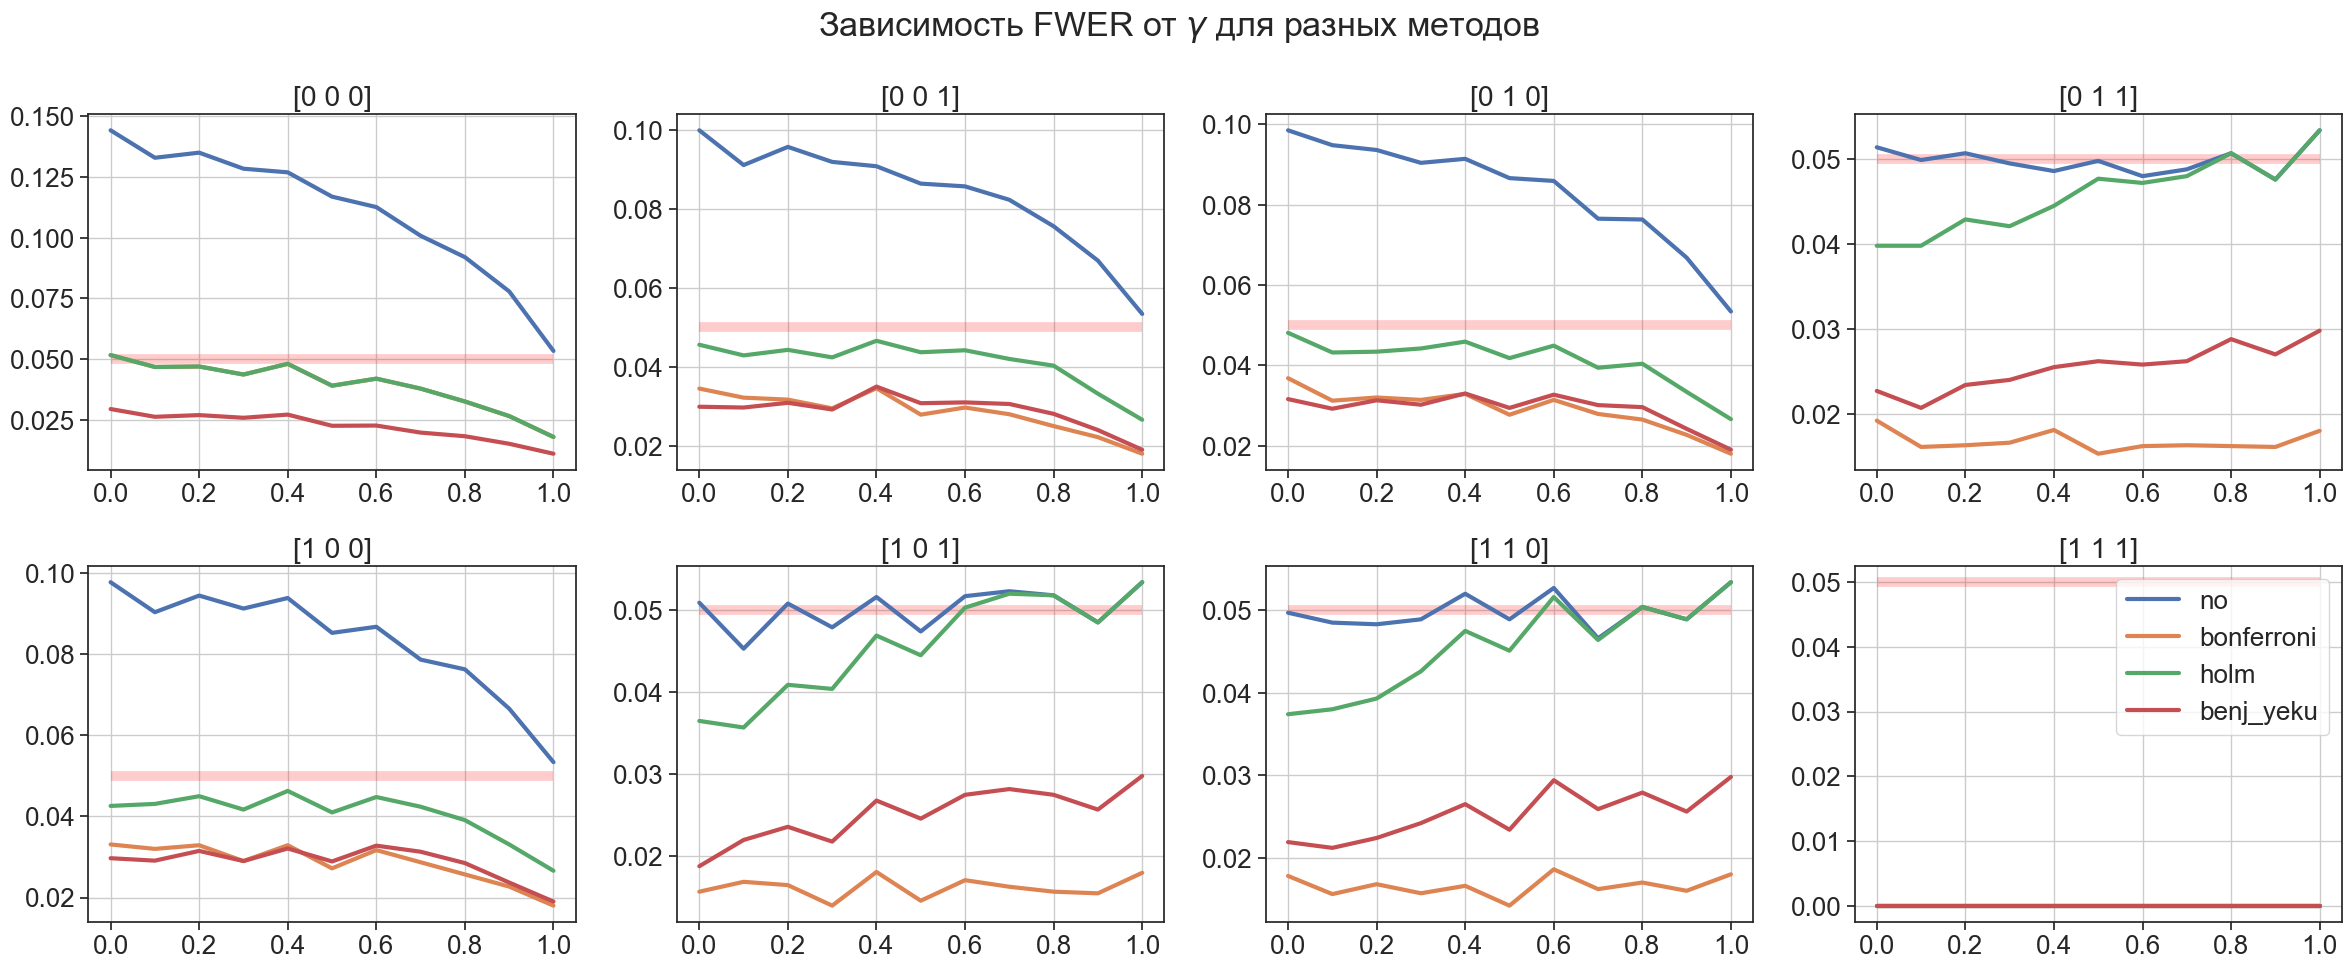

In [39]:
plt.figure(figsize=(24, 10))
plt.suptitle('Зависимость FWER от $\\gamma$ для разных методов')
# Для всех комбинаций верных и неверных гипотез
for mask_index, hypothesis_mask in enumerate(hypothesis_mask_list):
    plt.subplot(2, 4, mask_index+1)
    plt.title(hypothesis_mask)
    plt.grid()
    # Линия, соответствующая уровеню значимости
    plt.hlines(alpha, 0, 1, color='red', lw=7, alpha=0.2)

    # Отрисовка зависимостей по методам коррекции МПГ
    for correction_index, correction_name in enumerate(methods):
        fwer = (np.array(res[correction_name][mask_index]['v']) > 0).sum(axis=-1) / n_iters
        plt.plot(correlations_list, fwer, lw=3, label=correction_name)

# В случае FWER и FDR последний график пустой, там можно разместить легенду
plt.legend()
plt.tight_layout()

Проинтерпретируйте полученные результаты и сделайте выводы.

1. **Без коррекции:**
   - Вероятность FWER выше, чем при применении методов коррекции.
   - При отсутствии корреляции вероятность FWER превышает установленный уровень $\alpha = 0.05$.
   - Когда количество ложных гипотез равно 0 или 1:
     - FWER убывает с увеличением коэффициента корреляции.

2. **С коррекцией:**
   - При наличии 2 или 3 ложных гипотез:
     - Вероятность FWER для всех методов (даже без коррекции) находится на уровне 0.05 или ниже.
     - Для метода Холма и в случае отсутствия коррекции FWER увеличивается с ростом коэффициента корреляции.
     - Методы Бонферрони и Бенджамини-Йекутели обеспечивают стабильную вероятность FWER, практически не зависящую от коэффициента корреляции.

3. - Метод Холма допускает ошибки чаще, чем методы Бонферрони и Бенджамини-Йекутели.
   - Методы Бонферрони и Бенджамини-Йекутели демонстрируют более строгий контроль FWER.

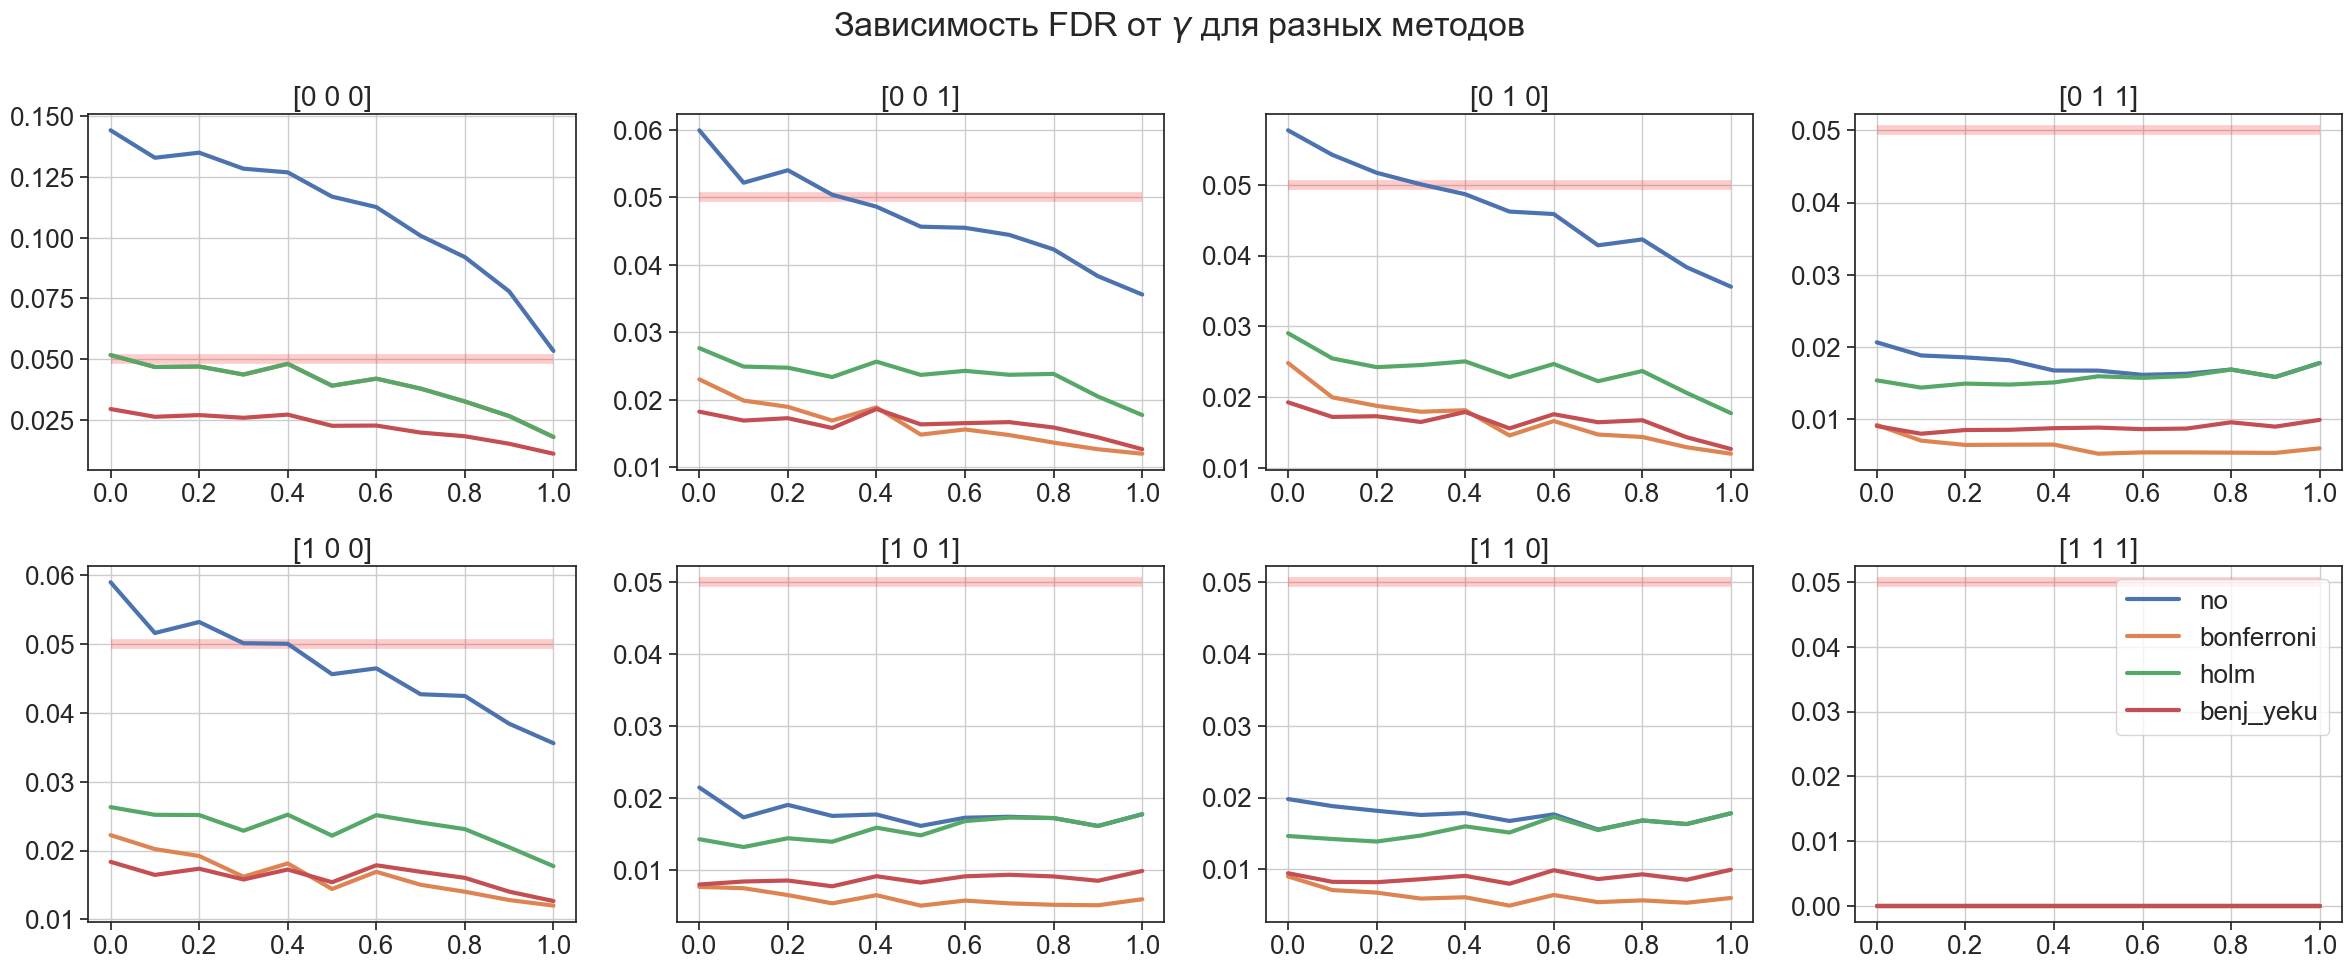

In [41]:
plt.figure(figsize=(24, 10))
plt.suptitle('Зависимость FDR от $\\gamma$ для разных методов')
# Для всех комбинаций верных и неверных гипотез
for mask_index, hypothesis_mask in enumerate(hypothesis_mask_list):
    plt.subplot(2, 4, mask_index+1)
    plt.title(hypothesis_mask)
    plt.grid()
    # Линия, соответствующая уровеню значимости
    plt.hlines(alpha, 0, 1, color='red', lw=7, alpha=0.2)

    # Отрисовка зависимостей по методам коррекции МПГ
    for correction_index, correction_name in enumerate(methods):
        fdr = (np.array(res[correction_name][mask_index]['v']) / np.maximum(np.array(res[correction_name][mask_index]['r']), 1)).mean(axis=-1)
        plt.plot(correlations_list, fdr, lw=3, label=correction_name)

# В случае FWER и FDR последний график пустой, там можно разместить легенду
plt.legend()
plt.tight_layout()

Выводы такие же, как и для FWER. Однако в случае, когда неверных гипотез больше, вероятность FDR визуально остается постоянной или уменьшается, а не растет как в случае FWER.

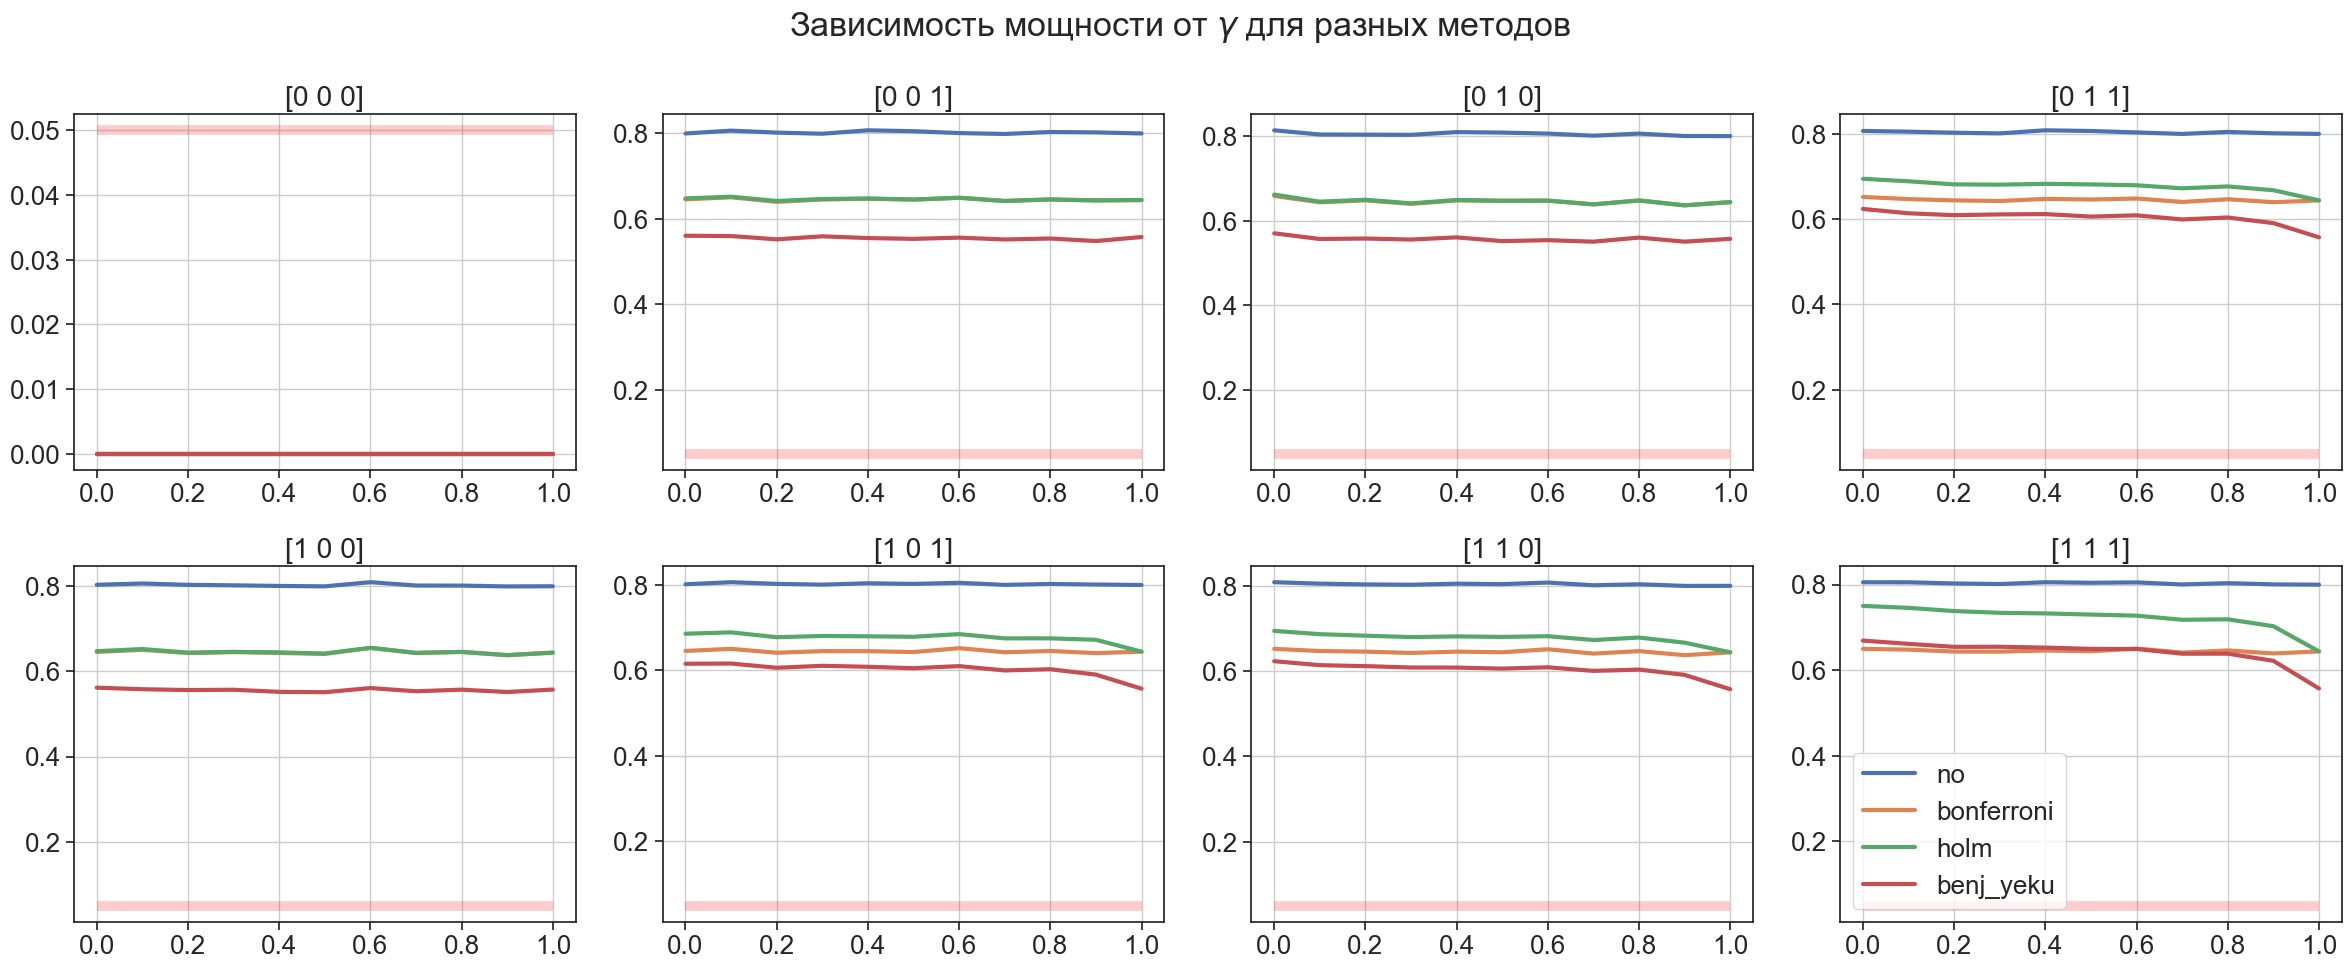

In [43]:
plt.figure(figsize=(24, 10))
plt.suptitle('Зависимость мощности от $\\gamma$ для разных методов')
# Для всех комбинаций верных и неверных гипотез
for mask_index, hypothesis_mask in enumerate(hypothesis_mask_list):
    plt.subplot(2, 4, mask_index+1)
    plt.title(hypothesis_mask)
    # Линия, соответствующая уровеню значимости
    plt.hlines(alpha, 0, 1, color='red', lw=7, alpha=0.2)
    plt.grid()

    # Отрисовка зависимостей по методам коррекции МПГ
    for correction_index, correction_name in enumerate(methods):
        power = (np.array(res[correction_name][mask_index]['u']) / np.maximum(np.zeros_like(np.array(res[correction_name][mask_index]['u'])) + hypothesis_mask.sum(), 1)).mean(axis=-1)
        plt.plot(correlations_list, power, lw=3, label=correction_name)

# В случае FWER и FDR последний график пустой, там можно разместить легенду
plt.legend()
plt.tight_layout()

1. Мощность методов не зависит от количества ложных гипотез или коэффициента корреляции. Она остается постоянной в этих условиях.

2. Метод без коррекции показывает наибольшую мощность, что логично, поскольку p-value не корректируются, и критерии становятся менее строгими.

3. 
   - Метод Холма всегда оказывается мощнее метода Бонферрони, что соответствует теоретическим ожиданиям, так как Holm менее консервативен.
   - Метод Бенджамини-Йекутели показывает наименьшую мощность среди всех методов, что объясняется его большей строгостью.

4. Причина низкой мощности метода Бенджамини-Йекутели:
   - Это связано с его низкой вероятностью отклонения верных гипотез, как видно на предыдущих графиках. Метод реже отвергает гипотезы, что снижает мощность, но обеспечивает лучший контроль над ложноположительными результатами.

Таким образом, методы демонстрируют ожидаемую и логически обоснованную иерархию мощности, от самого мощного (без коррекции) к самому консервативному (Бенджамини-Йекутели).

Проведите эксперименты для другого количества гипотез. При этом для ускорения можно перебирать не все комбинации гипотез, а только те, для которых результат будет отличаться. Какие именно &mdash; подумайте, проанализировав полученные выше графики.

In [44]:
sample_size = 100  # размер выборки на каждой итерации
n_iters = int(1e4)  # число экспериментов для каждой конфигурации
alpha = 0.05

theta_1 = 0.25  # значение из альтернативной гипотезы
n_hypothesis = 4  # количество гипотез

# Список всех комбинаций верных и неверных гипотез
hypothesis_mask_list = np.array(list(itertools.product([0, 1], repeat=n_hypothesis)))
print(hypothesis_mask_list)

# Перебираемые значения корреляции
n_correlations = 11
correlations_list = np.linspace(0, 1, n_correlations)
print(correlations_list)

[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [45]:
methods = ['no', 'bonferroni', 'holm', 'benj_yeku']
res = {}
for m in methods:
    res[m] = []
    for k in range(len(hypothesis_mask_list)):
        res[m].append({'v' : [], 'r' : [], 'u' : []})
        for q in range(len(correlations_list)):
            res[m][k]['v'].append([])
            res[m][k]['r'].append([])
            res[m][k]['u'].append([])

for q, correlation in enumerate(tqdm(correlations_list)):
    sample = sps.multivariate_normal([0, 0, 0, 0], np.eye(4) - (np.eye(4) - 1) * correlation, allow_singular=True).rvs(size=(n_iters, sample_size))
    for j, hypothesis_mask in enumerate(hypothesis_mask_list):
        sample_loop = sample + hypothesis_mask * theta_1
        p_value = sps.norm(0, np.sqrt(sample_size)).sf(sample_loop.sum(axis=1))
        for method in methods:
            if method == 'no':
                rejected = p_value < 0.05
            elif method == 'bonferroni':
                rejected =  bonf(p_value)
            elif method == 'holm':
                rejected =  holm(p_value)
            elif method == 'benj_yeku':
                rejected =  by(p_value)
            rejected = rejected.astype('bool')
            v = ((1 - hypothesis_mask) * rejected).sum(axis=-1)
            r = rejected.sum(axis=-1)
            u = r - v

            res[method][j]['v'][q].append(v)
            res[method][j]['r'][q].append(r)
            res[method][j]['u'][q].append(u)

  0%|          | 0/11 [00:00<?, ?it/s]

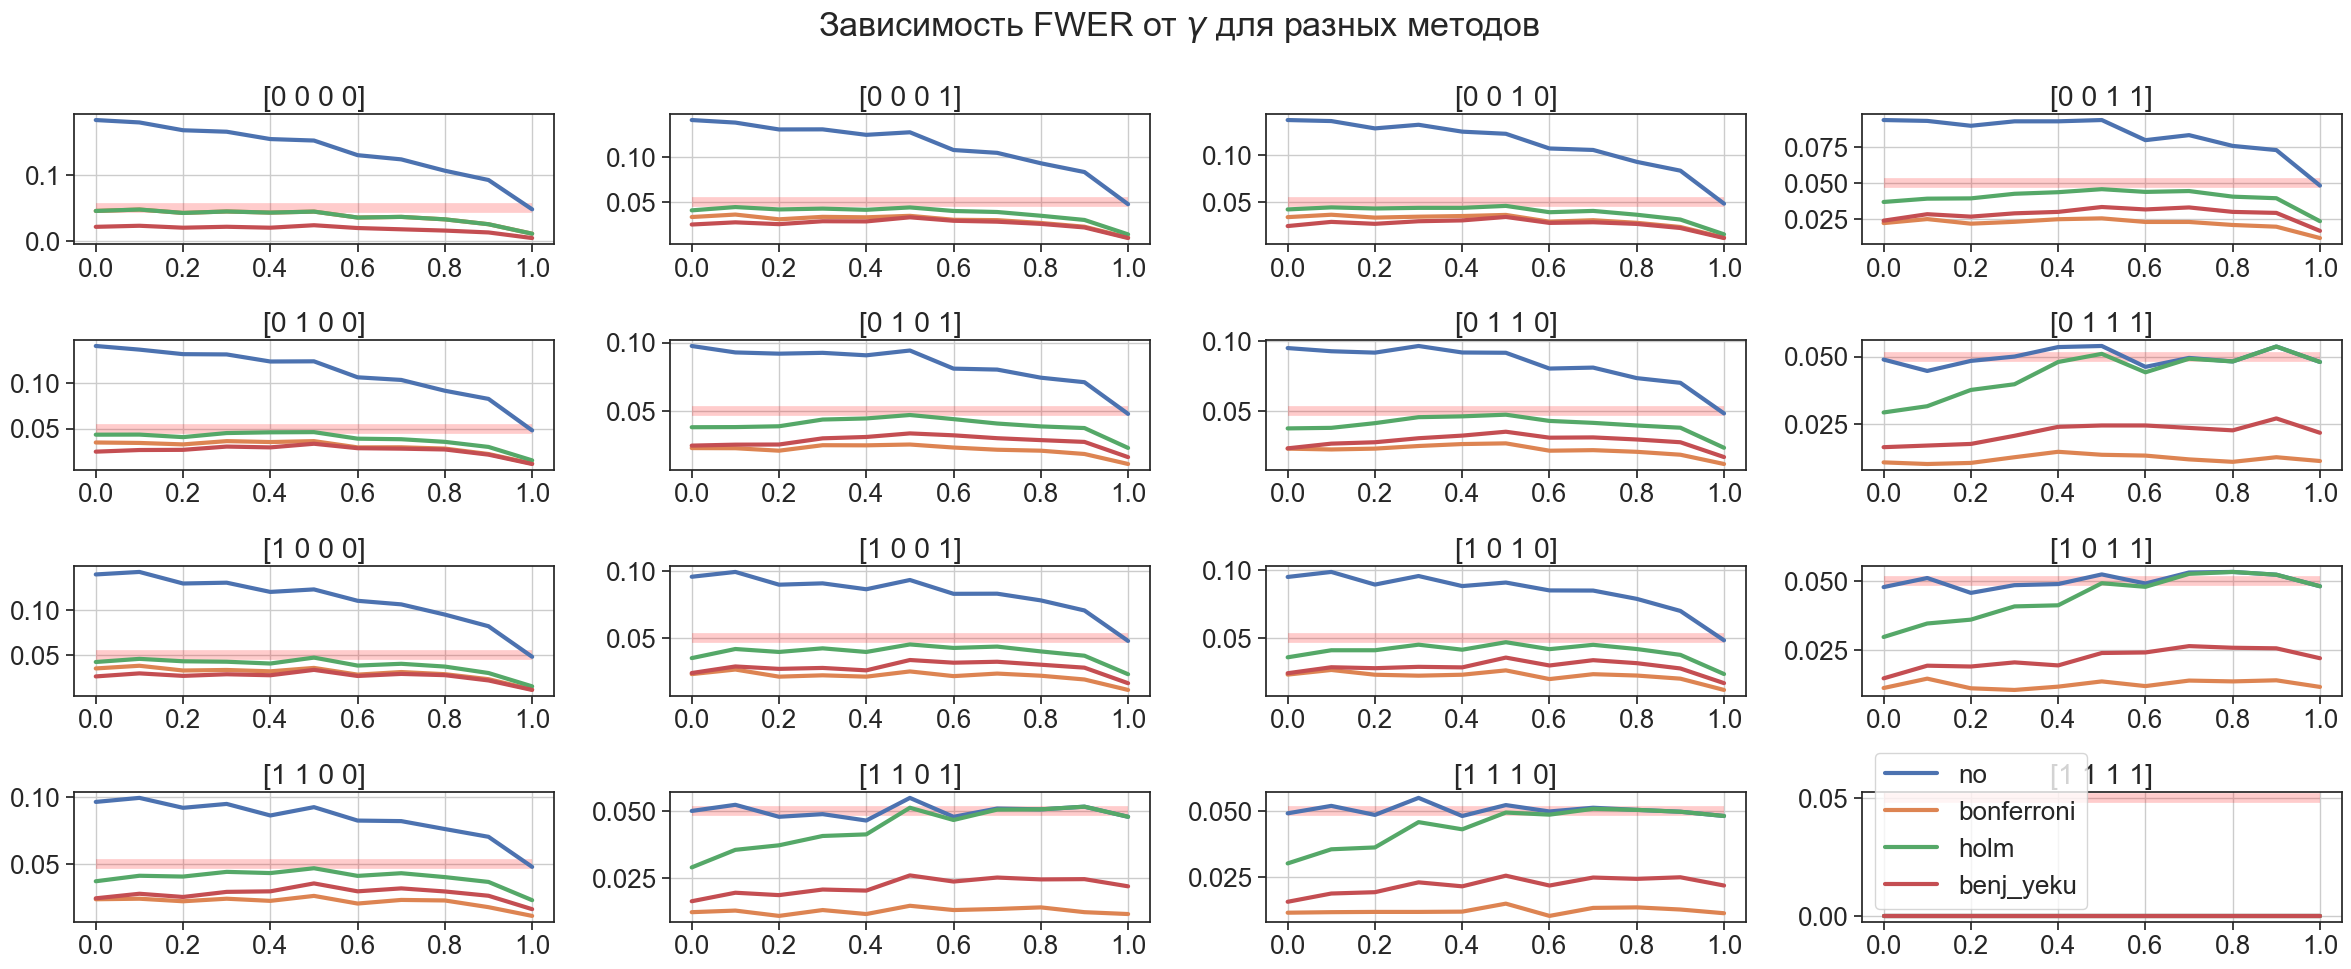

In [46]:
plt.figure(figsize=(24, 10))
plt.suptitle('Зависимость FWER от $\\gamma$ для разных методов')
# Для всех комбинаций верных и неверных гипотез
for mask_index, hypothesis_mask in enumerate(hypothesis_mask_list):
    plt.subplot(4, 4, mask_index+1)
    plt.title(hypothesis_mask)
    plt.grid()
    # Линия, соответствующая уровеню значимости
    plt.hlines(alpha, 0, 1, color='red', lw=7, alpha=0.2)

    # Отрисовка зависимостей по методам коррекции МПГ
    for correction_index, correction_name in enumerate(methods):
        fwer = (np.array(res[correction_name][mask_index]['v']) > 0).sum(axis=-1) / n_iters
        plt.plot(correlations_list, fwer, lw=3, label=correction_name)

# В случае FWER и FDR последний график пустой, там можно разместить легенду
plt.legend()
plt.tight_layout()

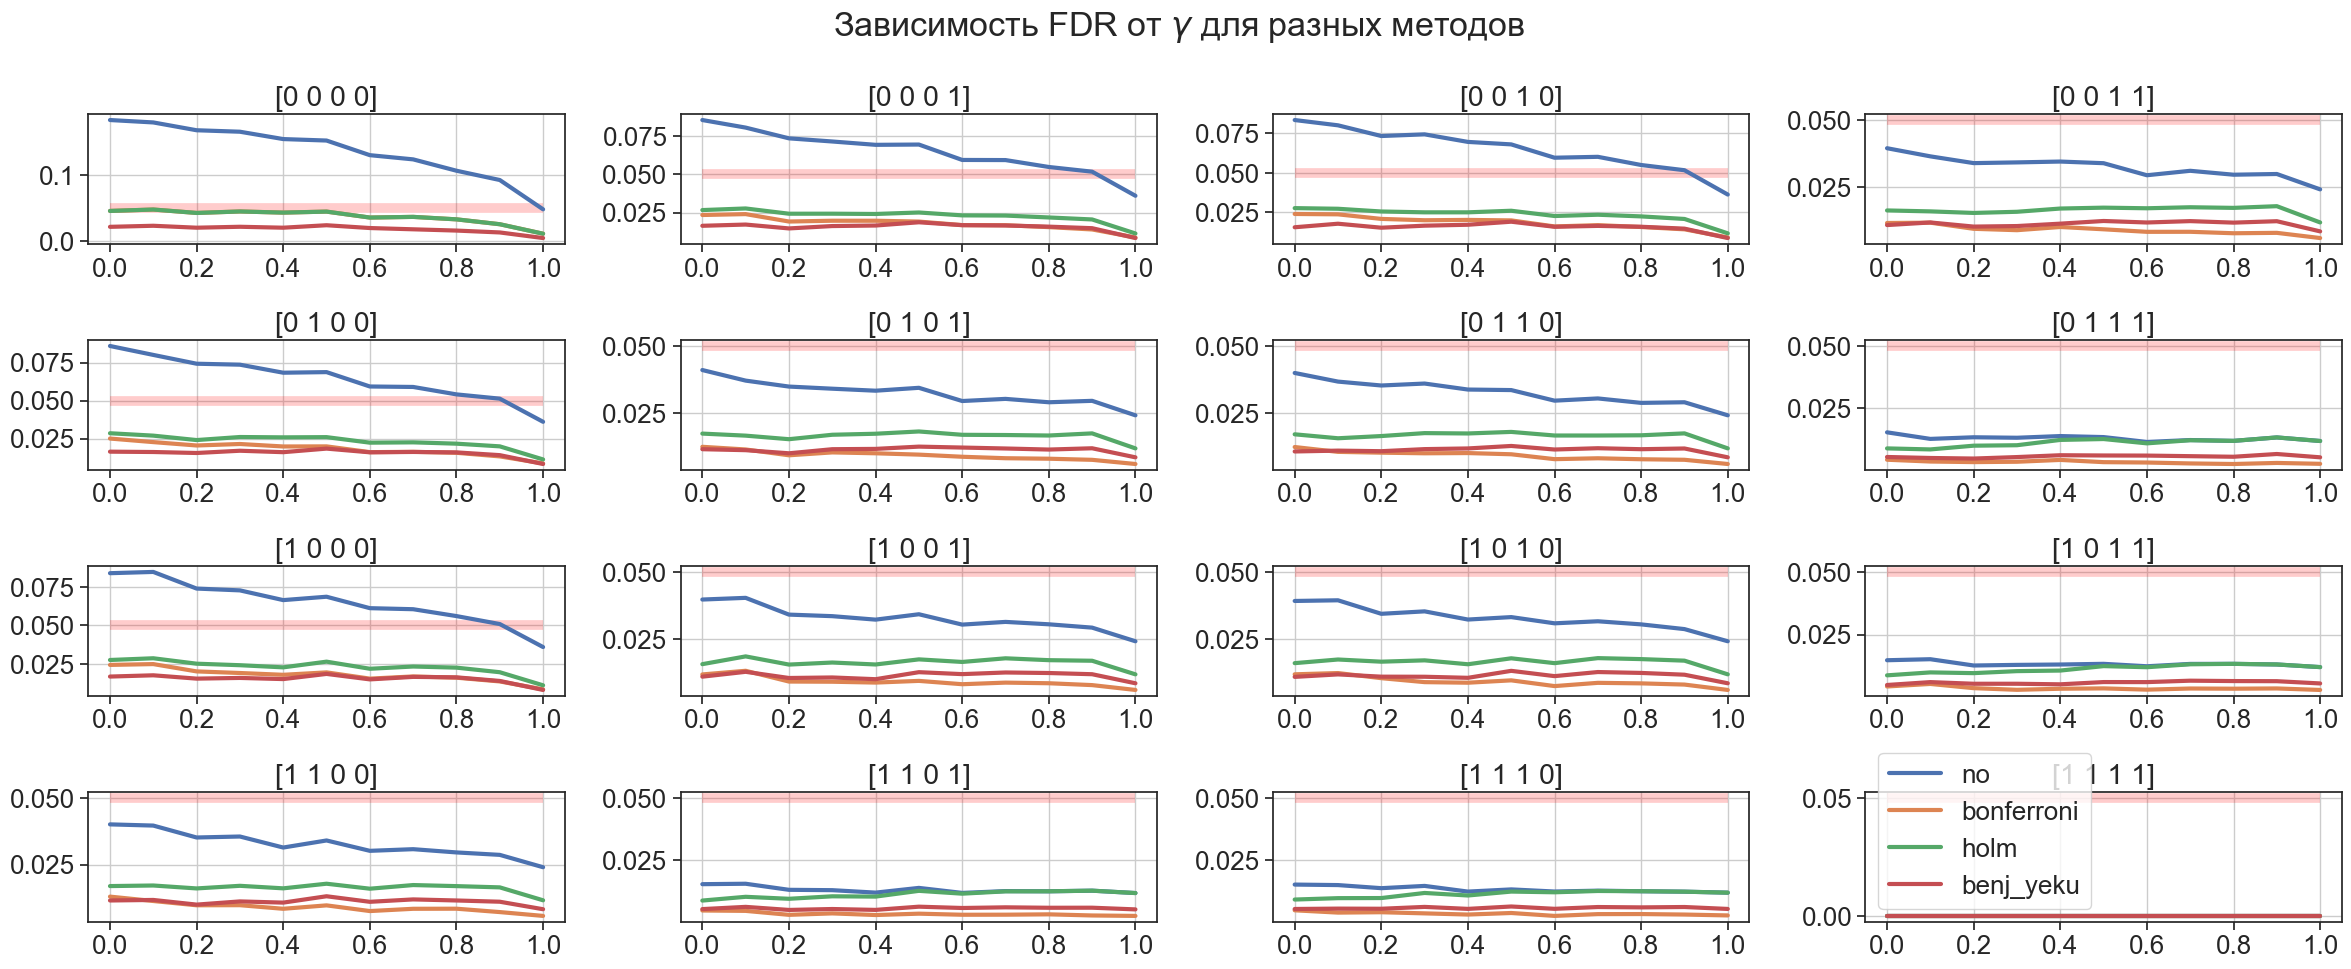

In [48]:
plt.figure(figsize=(24, 10))
plt.suptitle('Зависимость FDR от $\\gamma$ для разных методов')
# Для всех комбинаций верных и неверных гипотез
for mask_index, hypothesis_mask in enumerate(hypothesis_mask_list):
    plt.subplot(4, 4, mask_index+1)
    plt.title(hypothesis_mask)
    plt.grid()
    # Линия, соответствующая уровеню значимости
    plt.hlines(alpha, 0, 1, color='red', lw=7, alpha=0.2)

    # Отрисовка зависимостей по методам коррекции МПГ
    for correction_index, correction_name in enumerate(methods):
        fdr = (np.array(res[correction_name][mask_index]['v']) / np.maximum(np.array(res[correction_name][mask_index]['r']), 1)).mean(axis=-1)
        plt.plot(correlations_list, fdr, lw=3, label=correction_name)

# В случае FWER и FDR последний график пустой, там можно разместить легенду
plt.legend()
plt.tight_layout()

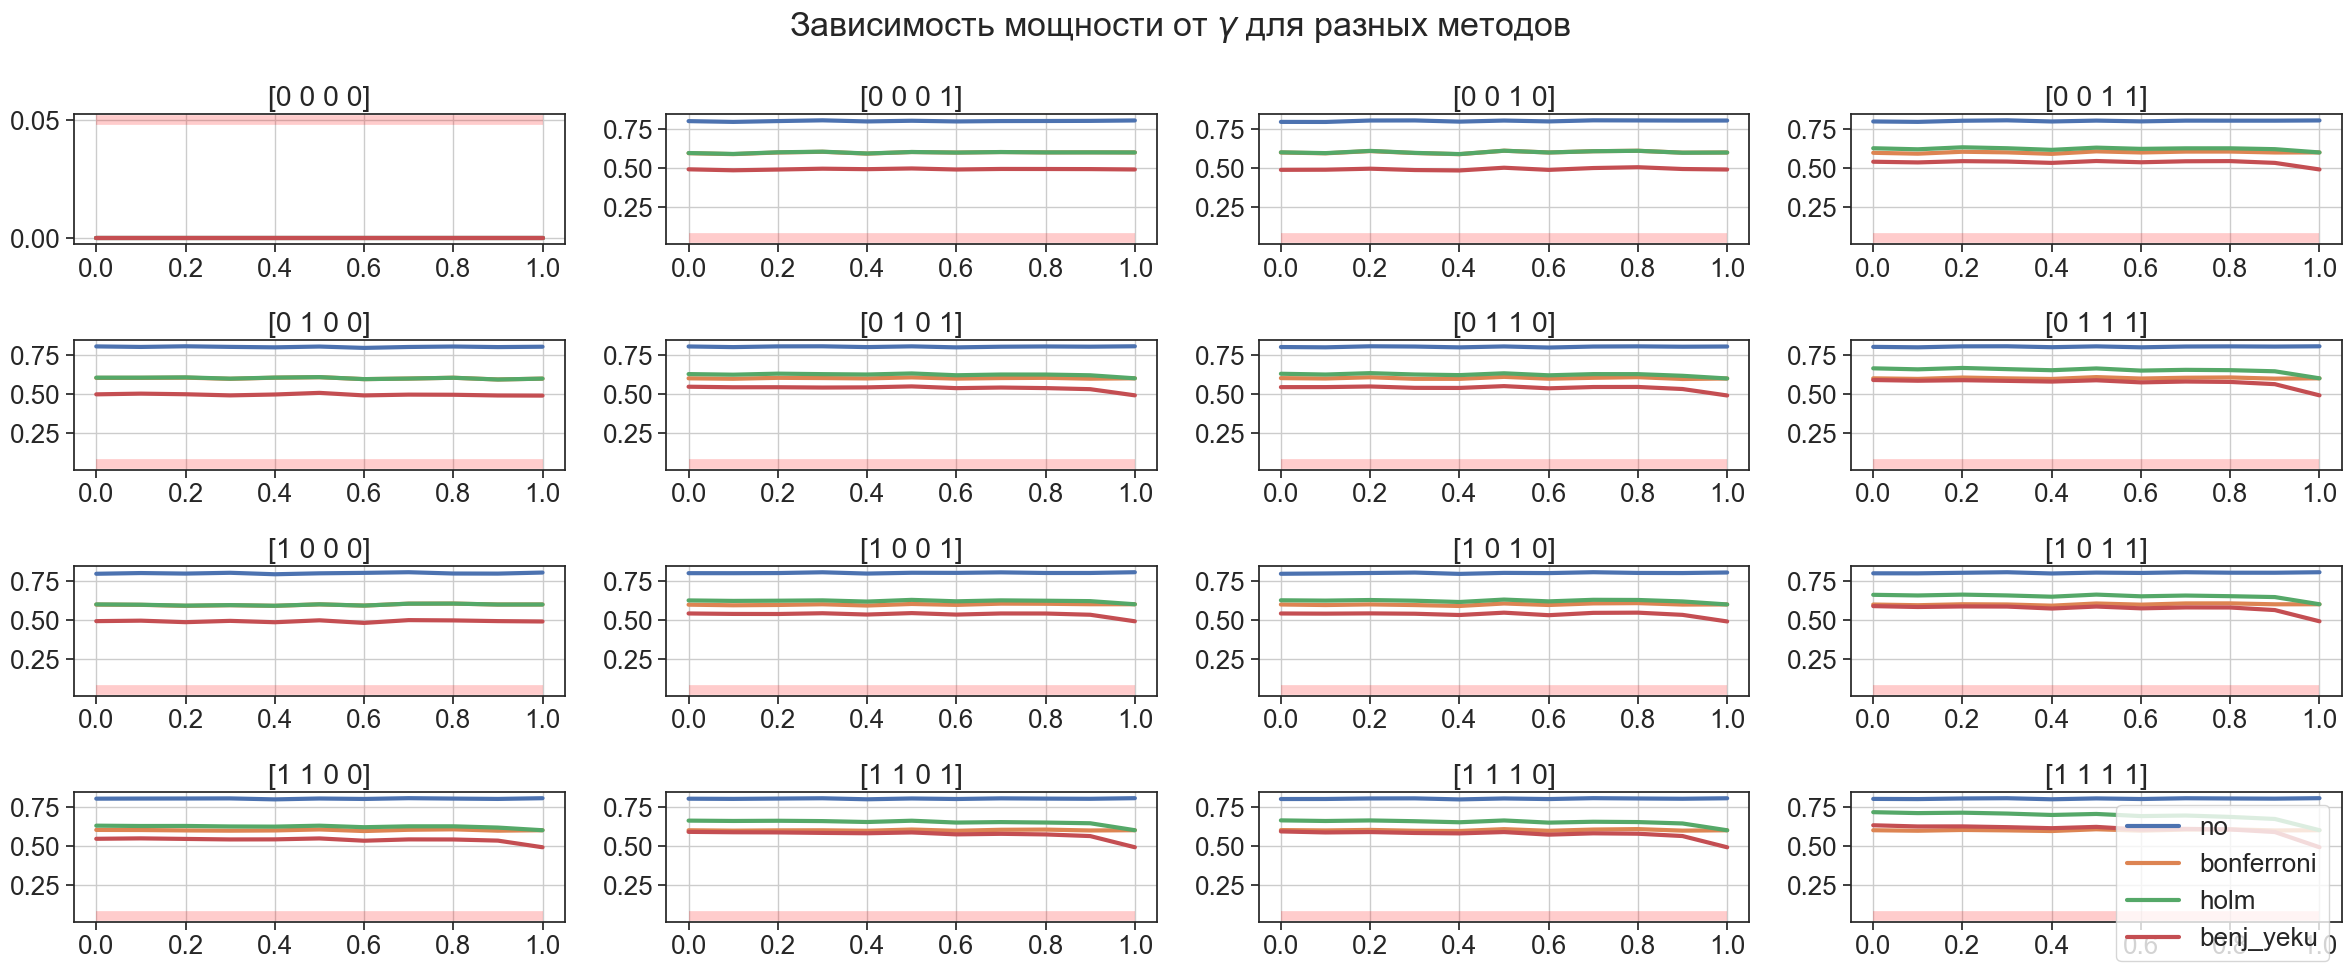

In [50]:
plt.figure(figsize=(24, 10))
plt.suptitle('Зависимость мощности от $\\gamma$ для разных методов')
# Для всех комбинаций верных и неверных гипотез
for mask_index, hypothesis_mask in enumerate(hypothesis_mask_list):
    plt.subplot(4, 4, mask_index+1)
    plt.title(hypothesis_mask)
    plt.grid()
    # Линия, соответствующая уровеню значимости
    plt.hlines(alpha, 0, 1, color='red', lw=7, alpha=0.2)

    # Отрисовка зависимостей по методам коррекции МПГ
    for correction_index, correction_name in enumerate(methods):
        power = (np.array(res[correction_name][mask_index]['u']) / np.maximum(np.zeros_like(np.array(res[correction_name][mask_index]['u'])) + hypothesis_mask.sum(), 1)).mean(axis=-1)
        plt.plot(correlations_list, power, lw=3, label=correction_name)

# В случае FWER и FDR последний график пустой, там можно разместить легенду
plt.legend()
plt.tight_layout()

Вывод:
Аналогично написанному выше: поведение графиков зависит от доли верных гипотез, поведение графиков мощности не зависит ни от количества верных гипотез, ни от коэффициента корреляции.